# Summary of this notebook

In this notebook, we develop models to predict whether a Reddit post belongs to the the "Composers" subreddit or the "Producers" subreddit.  After splitting our data into training and test sets, we select candidate models based on their cross-val accuracy scores.  After tuning hyperparameters, we find that Logistic Regression, Multinomial Naive Bayes, Random Forest, and Gradient Boosted Decision Trees all perfrom well at classifying posts.  We then create a stacked model that combines these 4 models and achieves an even higher accuracy score.  We then validate these results with our reserved test data before examining the ways in which our best model may fail to make a correct prediction.

Throughout the modeling process, we try many combinations of hyperparameters and text processing methods.  We report the general results of these various methods at the end of this notebook.

Additionally, as we create models, when possible we extract information from those models that may give some insight into their inner workings - such as feature importances and regression coefficients.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.metrics import ConfusionMatrixDisplay



#Import functions and preprocessors from previous notebook
from processing_functions import url_preprocessor, stem_processor

## Data Import

In [2]:
df_all = pd.read_csv('../data/combined.csv', index_col='id')

#Since Pandas converts empty strings to NaN's, we need to fill these in again
df_all.fillna('', inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 107hfj5 to 10b33q8
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        2325 non-null   object 
 1   text         2325 non-null   object 
 2   utc          2325 non-null   float64
 3   subreddit    2325 non-null   object 
 4   title_words  2325 non-null   int64  
 5   text_words   2325 non-null   int64  
 6   title_chars  2325 non-null   int64  
 7   text_chars   2325 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 163.5+ KB


## Add a column that combines title and body text

In [3]:
df_all['post'] = df_all[['title','text']].apply((lambda x : ' '.join(x)), axis=1)
df_all.head(2)

,title,text,utc,subreddit,title_words,text_words,title_chars,text_chars,post
id,,,,,,,,,
107hfj5,minature series,"Over 2022, I wrote about 30 little pieces for ...",1.673279e+09,Composers,2,128,15,657,"minature series Over 2022, I wrote about 30 li..."
107hah0,How can I get my music published?,"I tried being ""my own"" publisher on ASCAP but ...",1.673278e+09,Composers,8,142,33,613,How can I get my music published? I tried bein...


## Train/Test Split

We reserve 25% of our data in the dataframe `val_df`.  The remaining 75% of the data will be used to train our models; we will store this data in the dataframe `df`.  We will not use the `val_df` data until the validation stage at the end of the modeling process.

In [4]:
df, val_df = train_test_split(df_all,
                               random_state=123,
                               stratify=df_all['subreddit'])
df['subreddit'].value_counts()

Producers    930
Composers    813
Name: subreddit, dtype: int64

In [5]:
#Number of points left for our test data set
len(val_df)

582

## Scoring and Baseline Accuracy

In [6]:
df['subreddit'].value_counts(normalize=True)

Producers    0.533563
Composers    0.466437
Name: subreddit, dtype: float64

So if we used a null model that just guessed the most common class ("Producers") in all cases, our accuracy score would be about 53.4%. Since there is no obvious reason why misclassifying a "Producers" post as a "Composers" post should be of more concern than misclassifying a "Composers" post as a "Producers" post (and vice-versa), accuracy is a good metric to use to evaluate the models.  We will use this metric for the remainder of this notebook.

# Training models on title + body text

We'll begin by training models on both the titles and body texts of posts, but no other features.  Later we will try training the models on other sets of features, such as using just the titles instead of titles+body texts, and also including word counts.

In [7]:
X = df['post']
y = df['subreddit']

We will train the following types of classification models: Naive Bayes, Logistic Regression, $k$-Nearest Neighbors (kNN), Random Forest, and Gradient Boosted Decision Trees.  For each type of model, we will perform a hyperparameter grid search to find the model that achieves the highest cross-val Accuracy score.  Based on the results of previous grid searches, we'll adapt the hyperparameters over which we're grid searching.  Finally, we'll go back to any models that performed well and more finely tune their hyperparameters.

## Naive Bayes Classifier

In [8]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('nb', MultinomialNB())
])

In [9]:
nb_pipe_params = {
    'cvec__preprocessor': [url_preprocessor, ( lambda x : stem_processor(url_preprocessor(x)) )],
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.5, .7, 0.9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [10]:
nb_gs = GridSearchCV(nb_pipe, param_grid = nb_pipe_params, n_jobs=-1)

In [11]:
nb_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                     

In [12]:
#Examine best hyperparameters
nb_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': <function processing_functions.url_preprocessor(text)>}

In [13]:
nb_gs.best_score_

0.9357375753384053

This is a very good crossval score for our first attempt!

## Logistic Regression

In [14]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('ss',StandardScaler(with_mean=False)),
    ('lr', LogisticRegression())
])

In [15]:
lr_pipe_params = {
    'lr__C' : np.logspace(-2,2,12),
    
    'cvec__preprocessor': [url_preprocessor, ( lambda x : stem_processor(url_preprocessor(x)) )],
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [2],
    'cvec__max_df': [.5, .7, 0.9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [16]:
lr_gs = GridSearchCV(lr_pipe, lr_pipe_params, n_jobs=-1)

In [17]:
lr_gs.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                     

In [18]:
lr_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': <function processing_functions.url_preprocessor(text)>,
 'lr__C': 0.01}

In [19]:
lr_gs.best_score_

0.9093419622566941

This crossval score is still pretty good, but not as good as the Naive Bayes classifier.

### What we've learned so far

It seems that `CountVectorizer`'s parameters `min_df` being 2 works better than it being 3.  We'll try 1 as well (below).  Also, it seems that an `ngram_range` of `(1,1)` - i.e., the default of considering only single words - is generally best.  So for now, we'll save some computation time and set these parameters to these values.  Similarly, adding stemming (on top of the URL preprocessor) didn't seem to help in any case so far, so we'll stop using it.

Finally, `max_df` seems to be too large to be relevant (perhaps because no word appears in more than 50% of posts): both of the above gridsearches found the optimal `max_df` to be .5.  Any value smaller than this certainly defeats the point of having a `max_df`, so we'll drop this parameter.  

# kNN

In [20]:
knn_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [21]:
knn_pipe_params = {
    'knn__n_neighbors':[3,5,7,9],
    'knn__weights':['uniform','distance'],
    
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [1,2],
}

In [22]:
knn_gs = GridSearchCV(knn_pipe, param_grid = knn_pipe_params, n_jobs=-1)

In [23]:
knn_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [24]:
knn_gs.best_params_

{'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'knn__n_neighbors': 3,
 'knn__weights': 'uniform'}

In [25]:
knn_gs.best_score_

0.763648190231532

So again we find that `min_df=2` is best.  So next time, we'll drop `min_df=3` from consideration, but we'll also try `min_df=.01` (i.e., keep only those words that appear in at least 1% of posts).

This score is not nearly as good as the other models, so we won't bother with a more refined search.

# Random Forest

In [26]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('rf', RandomForestClassifier(random_state=42))
])

In [27]:
rf_pipe_params = {
    'rf__n_estimators':[50,100,150],
    'rf__max_depth':[None,5],
    'rf__min_samples_split':[2,5,10],
    'rf__ccp_alpha':[0,.01,.1],
    
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [2,.01],
}

In [28]:
rf_gs = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, n_jobs=-1)

In [29]:
rf_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [30]:
rf_gs.best_params_

{'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 150}

In [31]:
rf_gs.best_score_

0.9225290649804038

Again, this is a pretty good score.  And again we find that `min_df=2` seems to be working best.

# Gradient Boosted Decision Trees

In [32]:
boost_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('ss', StandardScaler(with_mean=False)),
    ('boost', GradientBoostingClassifier(random_state=42))
])

In [33]:
boost_pipe_params = {
    'boost__n_estimators': list(range(40,161,20)),
    'boost__max_depth': [3,4],

    
    'cvec__max_features': [1000,2000,3000,4000,5000],
    'cvec__min_df': [2],
}

In [34]:
boost_gs = GridSearchCV(boost_pipe, param_grid = boost_pipe_params, n_jobs=-1)

In [35]:
boost_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [36]:
boost_gs.best_params_

{'boost__max_depth': 4,
 'boost__n_estimators': 160,
 'cvec__max_features': 1000,
 'cvec__min_df': 2}

In [37]:
boost_gs.best_score_

0.9087721898363139

# Refining the models

We'll refine the models in the reverse order from the order in which we originally trained them.

### Gradient Boosted Decision Trees

In [38]:
#Adjusting learning rate before further refining
boost_pipe_params0 = {
    'boost__n_estimators': [50,100,150,200],
    'boost__max_depth': [3,4,5],
    'boost__learning_rate': np.logspace(-3,-1,8),
    
    'cvec__max_features': [500,1000,1500,2000],
    'cvec__min_df': [2],
}

In [39]:
boost_gs0 = GridSearchCV(boost_pipe, param_grid = boost_pipe_params0, n_jobs=-1)

In [40]:
boost_gs0.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [41]:
boost_gs0.best_params_

{'boost__learning_rate': 0.1,
 'boost__max_depth': 5,
 'boost__n_estimators': 200,
 'cvec__max_features': 1000,
 'cvec__min_df': 2}

In [42]:
boost_gs0.best_score_

0.9139363699239207

This model did somewhat better than the last one, but playing with the `learning_rate` did not help.  We'll use this information to look for a more refined model:

#### Refining again

In [43]:
#Adjusting learning rate before further refining
boost_pipe_params1 = {
    'boost__n_estimators': list(range(150,221,10)),
    'boost__max_depth': [4,5,6,7],
    
    'cvec__max_features': [700,800,900,1000,1100,1200],
    'cvec__min_df': [2],
}

In [44]:
boost_gs1 = GridSearchCV(boost_pipe, param_grid = boost_pipe_params1, n_jobs=-1)

In [45]:
boost_gs1.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [46]:
boost_gs1.best_params_

{'boost__max_depth': 5,
 'boost__n_estimators': 220,
 'cvec__max_features': 1000,
 'cvec__min_df': 2}

In [47]:
boost_gs1.best_score_

0.9139380166650198

The improvement from the second round of refining was rather miniscule.

### Random Forest

Let's see if we can do any better.  We'll try adding back bigrams this time, as well as adding in `min_samples_leaf`.

In [48]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('rf', RandomForestClassifier(random_state=42))
])

In [49]:
rf_pipe_params1 = {
    'rf__n_estimators':[100, 150, 200, 250],
    'rf__max_depth':[None,7],
    'rf__min_samples_split':[5,10],
    'rf__min_samples_leaf':[1,2,5,10],
    
    'cvec__max_features': [2500,3000,3500],
    'cvec__min_df': [2],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [50]:
rf_gs1 = GridSearchCV(rf_pipe, param_grid = rf_pipe_params1, n_jobs=-1)

In [51]:
rf_gs1.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [52]:
rf_gs1.best_params_

{'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 150}

In [53]:
rf_gs1.best_score_

0.9225241247571058

This more refined search didn't improve the score all that much.

### Random Forest Feature Importances

In [54]:
importances = rf_gs1.best_estimator_.named_steps['rf'].feature_importances_
word_names = rf_gs1.best_estimator_.named_steps['cvec'].get_feature_names_out()

importances_df = pd.DataFrame(importances, index=word_names)
importances_df = importances_df.sort_values(0, ascending=False)
importances_df

,0
piece,0.053739
score,0.052374
googlelink,0.034010
composition,0.028973
unknownlink,0.028644
...,...
developing,0.000000
exposition,0.000000
desk,0.000000
gmail,0.000000


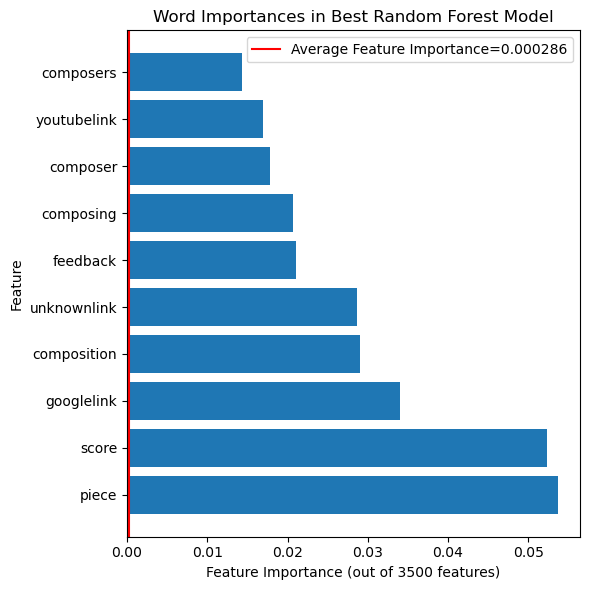

In [55]:
plt.figure(figsize=(6,6));
plt.barh(importances_df.iloc[0:10,0].index, importances_df.iloc[0:10,0]);
plt.xlabel('Feature Importance (out of 3500 features)');
plt.ylabel('Feature');
plt.title('Word Importances in Best Random Forest Model')

plt.axvline(x = 1/3500, color = 'r', label = f'Average Feature Importance={np.round(1/3500, 6)}');
plt.legend();
plt.tight_layout();
plt.savefig('../images/feature_importances.png')

Notice that the words "composition," "composer," and "composing" all have the same root.  One might therefore suggest that preprocessing the texts by stemming/lemmatizing their words could improve performance.  Our EDA suggests that this is not likely to be the case.  However, as our gridsearches indicate, include the `stem_processor` (alongside the `url_preprocessor`) actually makes performance somewhat worse overall.

### Logistic Regression

In [56]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('ss',StandardScaler(with_mean=False)),
    ('lr', LogisticRegression())
])

In [57]:
lr_pipe_params1 = {
    'lr__C' : np.logspace(-3,2,20),

    'cvec__max_features': [250, 500, 750, 1000, 1250, 1500, 1750, 2000],
    'cvec__min_df': [2],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [58]:
lr_gs1 = GridSearchCV(lr_pipe, lr_pipe_params1, n_jobs=-1)

In [59]:
lr_gs1.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [60]:
lr_gs1.best_params_

{'cvec__max_features': 1750,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.006158482110660267}

In [61]:
lr_gs1.best_score_

0.9110743338932252

Again, the more refined search did not improve the accuracy score much.

### Word importances via logistic regression coefficients

In [62]:
coefs = lr_gs1.best_estimator_.named_steps['lr'].coef_
var_names = lr_gs1.best_estimator_.named_steps['cvec'].get_feature_names_out()

coefs_df = pd.DataFrame(coefs[0], index=var_names)
coefs_df = coefs_df.sort_values(0, ascending=False)

#Examine the 25 features that most strongly indicate "Producers"
coefs_df.head(25)

,0
production,0.151330
song,0.114855
producing,0.107526
vocals,0.099993
sound,0.097368
effect,0.097290
producers,0.095106
beats,0.093999
download,0.091761
drum,0.090402


The words at the top of this list are the ones that the logistic regression "learned" are the strongest indicators of a post having come from the "Producers" subreddit (holding constant all other words in the post).  On the flip side, here are the words that it learned to be the strongest indicators of the "Composers" subreddit:

In [63]:
#Examine the 25 features that most strongly indicate "Composers"
coefs_df.tail(25).sort_values(0)

,0
score,-0.243516
unknownlink,-0.230798
googlelink,-0.190236
youtubelink,-0.187758
piece,-0.186329
composition,-0.184772
composing,-0.169663
piano,-0.128446
composer,-0.126108
feedback,-0.123903


It's interesting to note that *the most common types of links* all appear to be very strong indicators of the "Composers" subreddit.  I hypothesize that this is because our sample of the "Producers" subreddit had over 200 posts that had empty body text (perhaps because it was deleted by a mod) while the "Composers" subreddit had none with empty body text.  Since a large fraction of posts contain links to Youtube, Google, or some other website in their body text (but none do in their title), this might make the presence of *any link* be a strong indicator of "having body text," which in turn is a strong indicator of being from the Composers subreddit.

Or, there might simply be cultural differences between the two subreddits that make these links more likely among Composers.

## Naive Bayes

In [64]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('nb', MultinomialNB())
])

In [65]:
nb_pipe_params1 = {
    'nb__alpha': np.logspace(-2,2,9),
    
    'cvec__max_features': list(range(3250,4751,250)),
    'cvec__min_df': [2],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [66]:
nb_gs1 = GridSearchCV(nb_pipe, param_grid = nb_pipe_params1, n_jobs=-1)

In [67]:
nb_gs1.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [68]:
#Examine best hyperparameters
nb_gs1.best_params_

{'cvec__max_features': 3750,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 1.0}

In [69]:
nb_gs1.best_score_

0.9363106412409842

Again, the improvement is rather small.

# Summary of best models trained on titles + body text

So far, to avoid data leakage, we haven't touched the test data.  But to summarize our progress so far, we'll make a table of the crossval accuracy scores and test data accuracy scores of the best models so far.

In [70]:
names_dict = {'nb_gs1': 'Naive Bayes',
              'rf_gs1': 'Random Forest',
              'lr_gs1': 'Logistic Regression',
              'boost_gs1':'Gradient Boost'}

X_test = val_df['post']
y_test = val_df['subreddit']

results_dict = {}
for est in names_dict.keys():
    results_dict[names_dict[est]] = {
     'Crossval Score': locals()[est].best_score_,
     'Test Data Score': locals()[est].score(X_test, y_test)
    }
    
results_df = pd.DataFrame(results_dict).T
results_df.sort_values('Crossval Score', ascending=False)

,Crossval Score,Test Data Score
Naive Bayes,0.936311,0.917526
Random Forest,0.922524,0.914089
Gradient Boost,0.913938,0.908935
Logistic Regression,0.911074,0.903780


These models have performed rather well.  But would a stacked model, which combines their predictions, improve results even further?

## Stacked Model

In [71]:
names_dict.keys()

dict_keys(['nb_gs1', 'rf_gs1', 'lr_gs1', 'boost_gs1'])

In [72]:
locals()['nb_gs1'].best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=3750, min_df=2,
                                 preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [73]:
print(list(names_dict.keys()))

['nb_gs1', 'rf_gs1', 'lr_gs1', 'boost_gs1']


In [74]:
#The following list comprehension won't work, as locals() is local to the most local scope (which is only the list comp here):
#level1_estimators = [ (name, locals()[name].best_estimator_) for name in names_dict.keys()]

level1_estimators = []
for name in names_dict.keys():
    level1_estimators.append((name, locals()[name].best_estimator_))

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression(penalty='none'))

In [75]:
cvs = cross_val_score(stacked_model, X, y)

In [76]:
stacked_model.fit(X,y)

StackingClassifier(estimators=[('nb_gs1',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_features=3750,
                                                                 min_df=2,
                                                                 preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                                 stop_words=['i',
                                                                             'me',
                                                                             'my',
                                                                             'myself',
                                                                             'we',
                                                                             'our',
                                                                             'ours',
                              

In [77]:
results_dict['Stacked Model'] = {
     'Crossval Score': cvs.mean(),
     'Test Data Score': stacked_model.score(X_test, y_test)
    }

results_df = pd.DataFrame(results_dict).T
results_df.sort_values('Crossval Score', ascending=False)

,Crossval Score,Test Data Score
Stacked Model,0.940325,0.929553
Naive Bayes,0.936311,0.917526
Random Forest,0.922524,0.914089
Gradient Boost,0.913938,0.908935
Logistic Regression,0.911074,0.903780


So the stacked model achieves a noticeably higher accuracy score on the training and test data!

We are now done tuning our main models.  Later in this notebook, we explore the confusion matrices of these models and look at some of the posts that the Stacked Model misclassified.  But for now, we explore whether some of the assumptions that have held true for all of our modeling so far are in fact optimal.  We begin by trying to train a model on only the *titles* of posts rather than the titles plus body texts.

# Other Ideas 1: Training on Titles Only

For comparison, we'll train a Naive Bayes model on only the *titles* of the posts.

In [78]:
X_title = df['title']

In [79]:
nb_title_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor) ),
    ('nb', MultinomialNB())
])

In [80]:
nb_title_pipe_params = {
    'cvec__max_features': list(range(500,5001,500)),
    'cvec__min_df': [2, .1],
    'cvec__max_df': [.95, .9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [81]:
nb_title_gs = GridSearchCV(nb_title_pipe, param_grid = nb_title_pipe_params, n_jobs=-1)

In [82]:
nb_title_gs.fit(X_title, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                          

In [83]:
#Examine best hyperparameters
nb_title_gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [84]:
#Cross-val score
nb_title_gs.best_score_

0.8468283766426243

In [85]:
#Test score
X_test_title = val_df['title']
nb_title_gs.score(X_test_title, y_test)

0.8642611683848798

These are pretty good crossval and test data accuracy scores for training on just the titles!  However, the scores are much better when we train the models on the titles *and* the body texts of posts.

# Other Ideas 2: Including Word Counts

Do our models perform better if we give them the title and body text word counts as features?

In [86]:
X_words = df[['post','title_words','text_words']]
X_test_words = val_df[['post','title_words','text_words']]
X_words.head(2)

,post,title_words,text_words
id,,,
103osx2,halftime vs gross beat is there any audible di...,4,30
zoda66,"First Composition, what do you think ? Hi. I'm...",8,68


### Naive Bayes with Word Counts

In [87]:
#Count vectorize only the 'post' column
counter = ColumnTransformer(
 transformers=[
     ('cvec', CountVectorizer(stop_words=stopwords.words('english'), preprocessor = url_preprocessor),  'post'),
 ],
    remainder='passthrough'
)

In [88]:
nb_words_pipe = Pipeline([
    ('count', counter),
    ('nb', MultinomialNB())
])

In [89]:
nb_words_pipe_params = {
    'count__cvec__max_features': list(range(500,5001,500)),
    'count__cvec__min_df': [2, .1],
    'count__cvec__max_df': [.95, .9],
    'count__cvec__ngram_range': [(1, 1), (1, 2)]
}

In [90]:
nb_words_gs = GridSearchCV(nb_words_pipe, param_grid = nb_words_pipe_params, n_jobs=-1)

In [91]:
nb_words_gs.fit(X_words, y)

GridSearchCV(estimator=Pipeline(steps=[('count',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cvec',
                                                                         CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                    

In [92]:
#Examine best hyperparameters
nb_words_gs.best_params_

{'count__cvec__max_df': 0.95,
 'count__cvec__max_features': 5000,
 'count__cvec__min_df': 2,
 'count__cvec__ngram_range': (1, 2)}

In [93]:
#Cross-val score
nb_words_gs.best_score_

0.9259938082534663

In [94]:
#Test score
nb_words_gs.score(X_test_words, y_test)

0.9278350515463918

So the Naive Bayes model does not perform quite as well when we directly include word counts as it does when we do not.  Is the same true for the Random Forest model (our next-best performer overall)?

### Random Forest with Word Counts

In [95]:
rf_words_pipe = Pipeline([
    ('count', counter),
    ('rf', RandomForestClassifier(random_state=42))
])

In [96]:
#Use the same hyperparameters as the first Random Forest gridsearch we tried
rf_words_pipe_params = {
    'rf__n_estimators':[50,100,150],
    'rf__max_depth':[None,5],
    'rf__min_samples_split':[2,5,10],
    'rf__ccp_alpha':[0,.01,.1],
    
    'count__cvec__max_features': list(range(1000,5001,1000)),
    'count__cvec__min_df': [2,.01],
}

In [97]:
rf_words_gs = GridSearchCV(rf_words_pipe, param_grid = rf_words_pipe_params, n_jobs=-1)

In [98]:
rf_words_gs.fit(X_words, y)

GridSearchCV(estimator=Pipeline(steps=[('count',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cvec',
                                                                         CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                    

In [99]:
rf_words_gs.best_params_

{'count__cvec__max_features': 5000,
 'count__cvec__min_df': 2,
 'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150}

In [100]:
rf_words_gs.best_score_

0.9213895201396436

In [101]:
rf_words_gs.score(X_test_words, y_test)

0.9243986254295533

So just like with the Naive Bayes model, adding in word counts did not improve the scores.

# Other Ideas 3: No stopwords

Does *not removing stopwords* perhaps help performance?  How about if we allow bigrams?

In [102]:
nb_nostop_pipe = Pipeline([
    ('cvec', CountVectorizer(preprocessor=url_preprocessor)),
    ('nb', MultinomialNB())
])

In [103]:
nb_nostop_pipe_params = {
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [2],
    'cvec__max_df': [.95, .9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [104]:
nb_nostop_gs = GridSearchCV(nb_nostop_pipe, param_grid = nb_nostop_pipe_params, n_jobs=-1)

In [105]:
nb_nostop_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function url_preprocessor at 0x7f9cf8e40670>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95, 0.9],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [106]:
#Examine best hyperparameters
nb_nostop_gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [107]:
#Crossval score
nb_nostop_gs.best_score_

0.9294289101867405

In [108]:
#Test score
nb_nostop_gs.score(X_test, y_test)

0.915807560137457

So *not removing stopwords* somewhat hurts performance, whether or not we allow bigrams.

# Other ideas 4: No URL preprocessing

Does leaving URLs as they are, and not preprocessing them into strings like 'youtubelink', improve performance?

In [109]:
nb_nourls_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('nb', MultinomialNB())
])

In [110]:
nb_nourls_pipe_params = {
    'cvec__max_features': list(range(1000,5001,1000)),
    'cvec__min_df': [2],
    'cvec__max_df': [.95, .9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [111]:
nb_nourls_gs = GridSearchCV(nb_nourls_pipe, param_grid = nb_nourls_pipe_params, n_jobs=-1)

In [112]:
nb_nourls_gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                     

In [113]:
#Examine best hyperparameters
nb_nourls_gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [114]:
#Crossval score
nb_nourls_gs.best_score_

0.913378124691236

In [115]:
#Test score
nb_nourls_gs.score(X_test, y_test)

0.9054982817869416

This cross-val score is *more than 2% lower than the crossval score of our first Naive Bayes model*!  So including the URL preprocessing was definitely a big help to these models' performance.

Since we found that none of the implicit assumptions of our best models were wrong (i.e., doing otherwise did not improve performance), we now return to our best models.

# Evaluating Performance with Confusion Matrices

In [116]:
#Look at the accuracy scores again
results_df.sort_values('Crossval Score', ascending=False)

,Crossval Score,Test Data Score
Stacked Model,0.940325,0.929553
Naive Bayes,0.936311,0.917526
Random Forest,0.922524,0.914089
Gradient Boost,0.913938,0.908935
Logistic Regression,0.911074,0.903780


So far, we have evaluated models' performance using cross-val accuracy and test data accuracy scores.  Recall from the above that our training data set contains 53.4% posts from the "Producers" subreddit and 46.6% posts from the "Composers" subreddit.  This means that the baseline accuracy is relatively low, so accuracy scores above 90% are rather good.  Furthermore, since there is no obvious reason why misclassifying a "Producers" post as a "Composers" post should be of more concern than misclassifying a "Composers" post as a "Producers" post (and vice-versa), accuracy is a good metric to use to evaluate the models.  

Scores such as *sensitivity* and *specificity* would have little meaning here, as there is no obvious "positive" or "negative" class.  Nonetheless, it may be useful to examine the confusion matrix to see how the best models classified the posts.

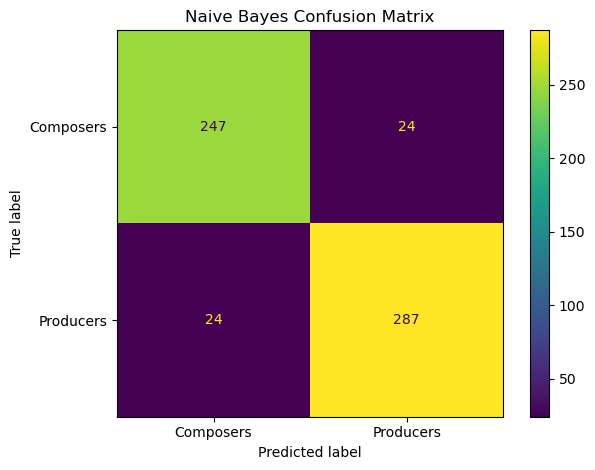

In [117]:
est = 'nb_gs1'
ConfusionMatrixDisplay.from_estimator(locals()[est], X_test, y_test);
plt.title(f'{names_dict[est]} Confusion Matrix');
plt.tight_layout();
plt.savefig(f'../images/{names_dict[est]}_Confusion_Matrix.png')

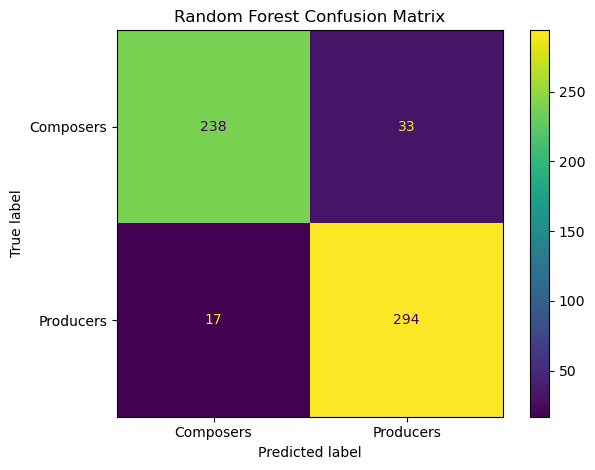

In [118]:
est = 'rf_gs1'
ConfusionMatrixDisplay.from_estimator(locals()[est], X_test, y_test);
plt.title(f'{names_dict[est]} Confusion Matrix');
plt.tight_layout();
plt.savefig(f'../images/{names_dict[est]}_Confusion_Matrix.png')

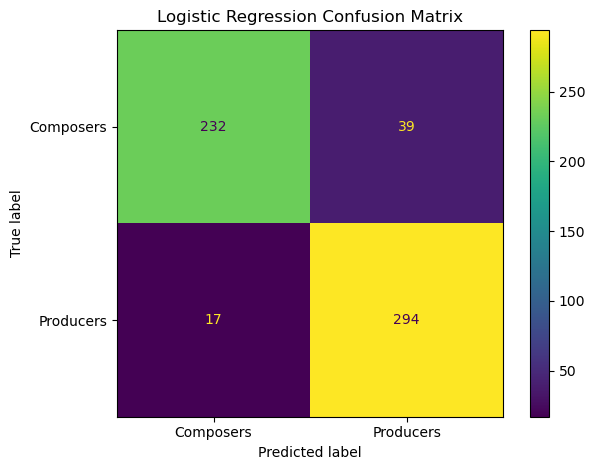

In [119]:
est = 'lr_gs1'
ConfusionMatrixDisplay.from_estimator(locals()[est], X_test, y_test);
plt.title(f'{names_dict[est]} Confusion Matrix');
plt.tight_layout();
plt.savefig(f'../images/{names_dict[est]}_Confusion_Matrix.png')

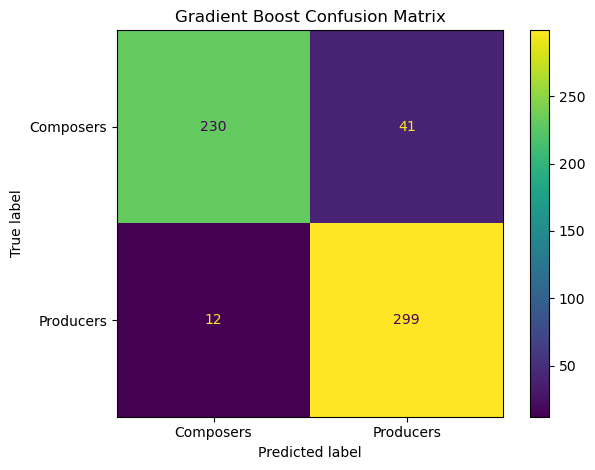

In [120]:
est = 'boost_gs1'
ConfusionMatrixDisplay.from_estimator(locals()[est], X_test, y_test);
plt.title(f'{names_dict[est]} Confusion Matrix');
plt.tight_layout();
plt.savefig(f'../images/{names_dict[est]}_Confusion_Matrix.png')

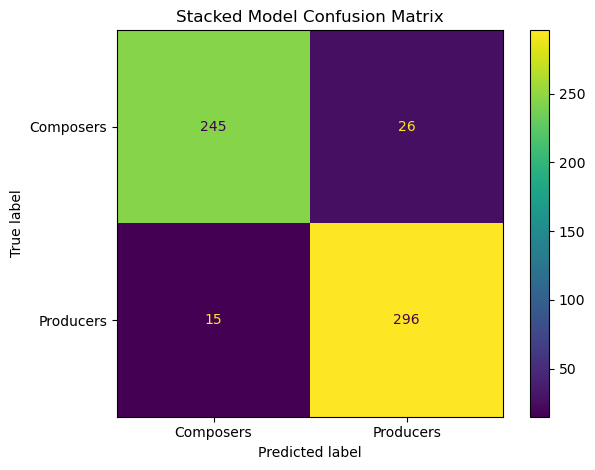

In [131]:
est = 'stacked_model'
ConfusionMatrixDisplay.from_estimator(stacked_model, X_test, y_test);
plt.title(f'Stacked Model Confusion Matrix');
plt.tight_layout();
plt.savefig(f'../images/Stacked Model_Confusion_Matrix.png')

As we can see from the above, the Naive Bayes model has the same number of misclassifications of both types.  However, all three of the other baseline models, as well as the stacked model, have a much larger number of misclassifications of the form "The post truly came from Composers, but I said it came from Producers."  That is, all of the models other than Naive Bayes have a slight bias towars the (slight) majority class.

As we can also see, the stacked model has the highest accuracy: it only misclassifies 40 of the 582 test data posts.

# Examining misclassified posts

Here, we'll examine some of the 40 test data posts that were misclassified by our best model (the Stacked Model).

In [132]:
#Get the predicted probabilities
probs = stacked_model.predict_proba(X_test)[:,0]
test_df = val_df[['title','text','subreddit']]
test_df['pred_comps_prob'] = probs
test_df.head(2)

,title,text,subreddit,pred_comps_prob
id,,,,
zyymug,*FREE* Couch Kit Vol. 1 - Tight drums by Orion...,[Couch Kit Vol. 1](https://www.dropbox.com/s/...,Producers,0.016943
zzrp0x,How would you make a sound appear to be coming...,,Producers,0.144330


## Misclassified "Producers" Posts

In [133]:
#Find the Producers posts that were mislabeled
mislabeled_prods = test_df[ (test_df['subreddit']=='Producers') & (test_df['pred_comps_prob']>.5)]
print(f"Number of Producers posts mislabeled as Composers posts: {len(mislabeled_prods)}")
mislabeled_prods.sort_values('pred_comps_prob', ascending=False)

Number of Producers posts mislabeled as Composers posts: 15


,title,text,subreddit,pred_comps_prob
id,,,,
10cawje,Made this video for fellow people who need a b...,[https://youtu.be/1P6ih1ko-UY](https://youtu.b...,Producers,0.975590
zq43en,Are there any AI programs or features that can...,"For example, it can just let you hear Freddy M...",Producers,0.935145
1066b9g,Is this song plagiarized?,"First of all, I apologize if this is not the r...",Producers,0.928463
zly37k,(Free music web resource) MusicWall is blowmin...,Hi there :) \n\nI just don't need LinkTree any...,Producers,0.922905
1047d5g,Quentin Miller Only Got 30K for Writing 6 Drak...,I feel for him in this interview. But it had ...,Producers,0.914286
10cyia0,How do you politely decline writing sessions y...,I’m in LA and it’s super common for people to ...,Producers,0.890199
104hvfu,I don’t feel very creative or “musical” lately,I quit drinking alcohol almost a month ago and...,Producers,0.864936
zxezg2,How to deal with meticulous perfectionism in m...,I’m a jazz/instrumental composer (and attempte...,Producers,0.836945
zr0kp9,What to expect during a video chat with A&R fr...,This week I submitted my track to a handful of...,Producers,0.737931


These posts are all the ones that the Stacked Model classified as "Composers" even though they came from the Producers subreddit.  Those posts at the top of this list are the ones that the Stacked Model was most certain were "Composers" - i.e., those "Producers" posts that the model had the most trouble correctly classifying.  As we can see, many of their titles look somewhat generic, meaning it may also have been difficult for a human to correctly guess that these posts came from the "Composers" subreddit.

Let's take a more detailed look at the top post:

In [134]:
bot_index_list = list(mislabeled_prods.sort_values('pred_comps_prob', ascending=False).index)
bot_index = bot_index_list[0]
print(mislabeled_prods['title'][bot_index])
print('='*100)
print(mislabeled_prods['text'][bot_index])

Made this video for fellow people who need a break from the stress ;0 enjoy
[https://youtu.be/1P6ih1ko-UY](https://youtu.be/1P6ih1ko-UY)


Even after watching the video (which our model certainly can't do), it's hard to guess which subreddit this post came from!  Let's try the second-to-top post:

In [135]:
bot_index = bot_index_list[1]
print(mislabeled_prods['title'][bot_index])
print('='*100)
print(mislabeled_prods['text'][bot_index])

Are there any AI programs or features that can take any mp3 recording of someone else's composition, for example, Bohemian Rhapsody by Queen and break it down into it's separate individual instrumentation?
For example, it can just let you hear Freddy Mercury's voice on it's own and cancels out all the other instruments/voices?


It seems pretty clear to a human that this post came from the "Producers" subreddit.  However, the word "composition" in the title is probably throwing the model off.

## Misclassified "Composers" Posts

In [136]:
#Find the Composers posts that were mislabeled
mislabeled_comps = test_df[ (test_df['subreddit']=='Composers') & (test_df['pred_comps_prob']<.5)]
print(f"Number of Composers posts mislabeled as Producers posts: {len(mislabeled_comps)}")
mislabeled_comps.sort_values('pred_comps_prob')

Number of Composers posts mislabeled as Producers posts: 26


,title,text,subreddit,pred_comps_prob
id,,,,
1021772,Sound effect of a specific instrument,What is the instrument that creates the effect...,Composers,0.021840
yw4s88,Question about Metropolis Ark 1 choirs,"If anyone here has used Metropolis Ark 1, you'...",Composers,0.030536
z8rwb0,Does anybody know a realistic orchestral sound...,"I'm making a song in fl studio, and the orches...",Composers,0.036676
ynp6m5,Question regarding a progression,I am tryna make a song where the intro is an A...,Composers,0.037253
z8w2ei,What are the best orchestral strings sf2 files?,"I was making a song in fl studio, and most of ...",Composers,0.037594
zkxgc6,Installing EastWest sounds,Just downloaded my first EW sound library and ...,Composers,0.037857
xn3q2u,Choral MIDI with lyrics,I would love to have any software/site that ca...,Composers,0.038988
yy4en5,Could this be a good tool to manage music proj...,"Hi, I've been thinking about developing a spec...",Composers,0.044179
z0va9x,Getting started with a DAW.,"Hello everyone, for the past 2 years I've been...",Composers,0.058151


These posts are all the ones that the Stacked Model classified as "Producers" even though they came from the Composers subreddit.  Those posts at the top of this list are the ones that the Stacked Model was most certain were "Producers" - i.e., those "Composers" posts that the model had the most trouble correctly classifying.  Again, judging by the titles, many of these might also be difficult for a human to classify.

Let's take a more detailed look at the top post:

In [137]:
top_index_list = list(mislabeled_comps.sort_values('pred_comps_prob').index)
top_index = top_index_list[0]
print(mislabeled_comps['title'][top_index])
print('='*100)
print(mislabeled_comps['text'][top_index])

Sound effect of a specific instrument
What is the instrument that creates the effect of hitting a hammer against a metal pipe? It’s somewhat like a blacksmith using his hammer but it’s a much bigger sound. It’s used in some marvel movies. I’ve looked everywhere and can’t seem to find the name of it.


Now that is indeed a hard post to classify!

In [138]:
top_index = top_index_list[1]
print(mislabeled_comps['title'][top_index])
print('='*100)
print(mislabeled_comps['text'][top_index])

Question about Metropolis Ark 1 choirs
If anyone here has used Metropolis Ark 1, you'll notice the excellent choir samples, both Male and Female. But the thing I wanted to point attention to is the Marcato and Staccato, where with each note is punctuated with a different syllable, It doesn't seem to be "Do re me la...", and I just wanted to know if there's a specific name for this style of singing? Okay, obviously when you choose the note it choses a random syllable, but it sounds impressive and I want to learn a bit more about it, and if there's a way to notate such singing (or would you consider it chanting?)


This post does seem to contain several words that come from classical music (like "Staccato"), making it likely that a human being would correctly predict that it came from the "Composers" subreddit.  However, these words probably did not appear frequently enough in the training data for `CountVectorizer` to keep them as features.  Thus, it pays no attention to these words that are "uncommon but strong signals."  It is probably judging that this post comes from "Producers" since it contains the word "samples" - a common term among music producers.

One technique that may help a model's performance on such posts would be to use the **frequency ratios** of words in the training data, rather than their *overall* frequencies in the training data, to determine which words should be kept as features after count-vectorization.  For example, the word "Staccato" is uncommon overall in the training data, but its *frequency ratio* = (frequency in Composers posts)/(frequency in Producers posts) is likely quite high.

The [experimental code](./experimental/frequency_ratio_modeling.ipynb) begins implementing analysis based on frequency ratios.  However, it is difficult to incorporate this method into `sklearn` pipelines, as a frequency ratio-based feature selector is, in `sklearn` terminology, a "transformer that needs to look at the $y$-values of the training data, not just the $X$-values."  `sklearn` does not support such transformers by default.

# Conclusions

## Everything we've learned about how to make a good "bag of words" classification model

In [139]:
results_df.sort_values('Crossval Score', ascending=False)

,Crossval Score,Test Data Score
Stacked Model,0.940325,0.929553
Naive Bayes,0.936311,0.917526
Random Forest,0.922524,0.914089
Gradient Boost,0.913938,0.908935
Logistic Regression,0.911074,0.903780


In this project, we attempted to achieve a high accuracy score when classifying Reddit posts between the [r/composer](https://www.reddit.com/r/composer/) and [r/musicproduction](https://www.reddit.com/r/musicproduction/) subreddits.  We tried to push the limits of "bag of words" models, using fewer than 2400 data points.  With the exception of the $k$-Nearest Neighbors model, all of the main models we attempted to train performed rather well after proper hyperparameter tuning: their cross-val and test-data accuracy scores were all above 90% and appear in the table above.

The models in the table above were trained on the concatenated title + body text data of all the subreddit posts.  None of the following generally improved performance:
- Adding in word counts (from body text and title)
- Adding in bigrams
- Training on titles only (no body text)
- Setting `CountVectorizer`'s `min_df` to a value other than 2; that is, including words that appear only once or excluding words that "do not appear frequently enough" (unless by "frequently enough" we mean "more than once")
- Stemming words before count-vectorizing

The following techniques significantly helped the models' performance:
- **Preprocessing texts by replacing URLs with words representing the website to which they link**
- **Removing stop words**
- **Stacking the best models together**

Indeed, URL preprocessing improved accuracy by more than 2%, and stacking improved performance on the test data by more than 1%.  Our best-performing model is the Stacked Model built from the other four models in the table above; **we recommend the Stacked Model as the "production model" for further classification tasks between these two subreddits**.

The techniques that yielded success in this project are also likely to yield success in similar Natural Language Processing classification problems.  However, some of the techniques (listed above) that *did not* improve the performance of our models may also be helpful, depending on the task at hand.

Finally, "bag of words" classification models may benefit from selecting features (words) using their *frequency ratios* across the two classes rather than their overall frequencies in the corpus.  Further work is needed to test the degree to which classification models can benefit from this technique.